# Importing Libraries

In [8]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os.path as op
import pickle

# Data Fetching

In [9]:
A1=np.empty((0,5),dtype='float32')
U1=np.empty((0,7),dtype='float32')
node=['150','149','147','144','142','140','136','61']
mon=['Apr','Mar','Aug','Jun','Jul','Sep','May','Oct']
for j in node:
  for i in mon:
    inp= pd.read_csv('data_gkv/AT510_Node_'+str(j)+'_'+str(i)+'19_OutputFile.csv',usecols=[1,2,3,15,16],low_memory=False)
    out= pd.read_csv('data_gkv/AT510_Node_'+str(j)+'_'+str(i)+'19_OutputFile.csv',usecols=[5,6,7,8,17,18,19],low_memory=False)
    
    inp=np.array(inp,dtype='float32')
    out=np.array(out,dtype='float32')
    
    A1=np.append(A1, inp, axis=0)
    U1=np.append(U1, out, axis=0)

print(A1)
print(U1)


[[1.50000e+02 1.90401e+05 7.25000e+02 2.75500e+01 8.03900e+01]
 [1.50000e+02 1.90401e+05 8.25000e+02 2.75600e+01 8.03300e+01]
 [1.50000e+02 1.90401e+05 9.25000e+02 2.75800e+01 8.02400e+01]
 ...
 [6.10000e+01 1.91020e+05 1.94532e+05 2.93700e+01 7.52100e+01]
 [6.10000e+01 1.91020e+05 1.94632e+05 2.93500e+01 7.52700e+01]
 [6.10000e+01 1.91020e+05 1.94732e+05 2.93400e+01 7.53000e+01]]
[[ 28.     3.   -52.   ...  16.97  19.63  20.06]
 [ 28.    15.   -53.   ...  16.63  19.57  23.06]
 [ 31.    16.   -55.   ...  17.24  19.98  20.24]
 ...
 [ 76.    12.   -76.   ...   3.47   3.95   4.35]
 [ 75.    13.   -76.   ...   3.88   4.33   4.42]
 [ 76.    12.   -75.   ...   3.46   4.07   4.28]]


# Min Max Scaler

In [10]:
from sklearn.preprocessing import MinMaxScaler
import warnings
scaler_obj=MinMaxScaler()
X1=scaler_obj.fit_transform(A1)
Y1=scaler_obj.fit_transform(U1)

warnings.filterwarnings(action='ignore', category=UserWarning)

# Parameter Tuning

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import RandomizedSearchCV

def hyperParameterTuning(X_train, y_train):
    param_tuning = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [7,8,10,],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7],
        'n_estimators' : [80,90,100,200,400,1000],
        'objective': ['reg:squarederror','count:poisson']
    }

    xgb_model = XGBRegressor(tree_method='gpu_hist', gpu_id=0)

    gsearch = RandomizedSearchCV(estimator = xgb_model, param_distributions = param_tuning, n_iter = 5, cv = 2, verbose=2, random_state=0, n_jobs = -1)

    
    grid_result = MultiOutputRegressor(gsearch).fit(x_train, y_train)

    return grid_result.estimators_[0].best_params_

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X1,Y1,test_size=0.25,random_state=0)

params=hyperParameterTuning(x_train,y_train)
params

# Model

In [12]:
# Splitting Data into training and testing dataset
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X1,Y1,test_size=0.25,random_state=42)

from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor

#creating object of sgboostregressor
model1=MultiOutputRegressor(XGBRegressor(tree_method='gpu_hist', gpu_id=0,max_depth=8,cosample_bytree=.5,learning_rate=.1,min_child_weight=3,
                   n_estimators=200,subsample=.7))

#training the model
model_fit1=model1.fit(x_train, y_train)
print("Model training is Done!!")

#saving as file
filename1 = 'Models_File/xgboost.sav'
pickle.dump(model_fit1, open(filename1, 'wb'))

[14:48:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "cosample_bytree" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:48:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "cosample_bytree" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:48:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "cosample_bytree" } might not be use

# Error Analysis

In [13]:
from sklearn.metrics import r2_score
from sklearn import metrics
train_sizes=['NO2','O3','NO','CO','PM1','PM2.5','PM10']

#finding out the r2 score
y_train_pred1=model1.predict(x_train)
r2_train1=r2_score(y_train,y_train_pred1,multioutput='variance_weighted')

y_test_pred1=model1.predict(x_test)
r2_test1=r2_score(y_test,y_test_pred1,multioutput='variance_weighted')

print('r2 score on train data '+str(r2_train1))
print('r2 score on test data '+ str(r2_test1))

xgboost_mae=metrics.mean_absolute_error(y_test, y_test_pred1)
xgboost_mse=metrics.mean_squared_error(y_test, y_test_pred1)
xgboost_rmse=np.sqrt(xgboost_mse)
print('Mean Absolute Error:',xgboost_mae)
print('Mean Squared Error:',xgboost_mse )
print('Root Mean Squared Error:',xgboost_rmse)
print(' \n')

r2 score on train data 0.9315455074103038
r2 score on test data 0.9310061554157045
Mean Absolute Error: 0.0008703509
Mean Squared Error: 9.53231e-06
Root Mean Squared Error: 0.003087444
 



# y-test vs y-predict

Y_Test: [[0.00011559 0.06553685 0.00011085 ... 0.0021448  0.0014142  0.00052142]
 [0.00011088 0.06553695 0.00012144 ... 0.01090628 0.00639894 0.00234271]
 [0.0001138  0.06553686 0.00011756 ... 0.02938369 0.01855402 0.00761428]
 ...
 [0.00011103 0.06553663 0.00011547 ... 0.05674056 0.03595096 0.01243099]
 [0.00011477 0.06553688 0.00010965 ... 0.00815022 0.00468672 0.00148292]
 [0.00010879 0.06553657 0.00012025 ... 0.00375339 0.00246608 0.00081172]]
Y_Test_Predict: [[ 0.00011304  0.06553669  0.0001106  ...  0.00318311  0.00199797
   0.00069842]
 [ 0.0001118   0.06553669  0.0001218  ...  0.01089094  0.00596268
   0.0024739 ]
 [ 0.00011329  0.06553669  0.00011889 ...  0.01406166  0.00932753
   0.00340562]
 ...
 [ 0.00011293  0.06553669  0.00011783 ...  0.04976198  0.0315338
   0.01107676]
 [ 0.00011323  0.06553669  0.00011179 ...  0.00104445 -0.00108336
   0.00037224]
 [ 0.0001118   0.06553669  0.00011662 ...  0.00419286  0.00318478
   0.00175163]]


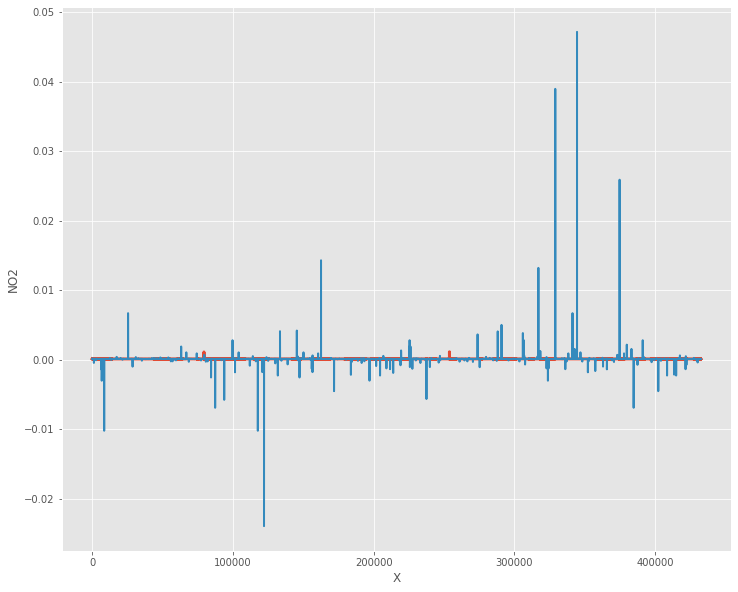

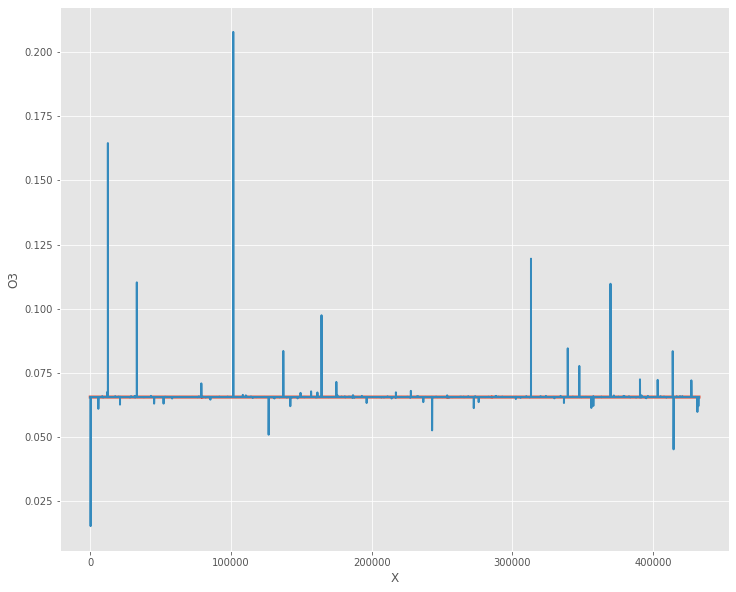

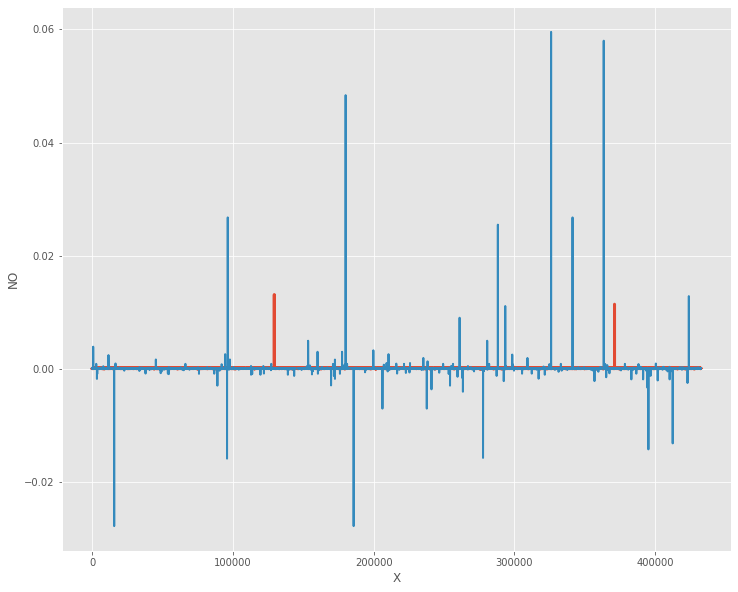

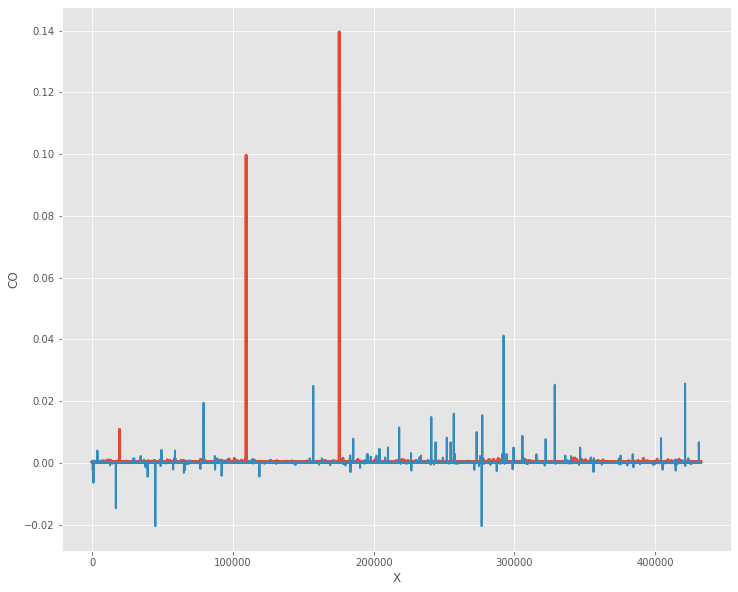

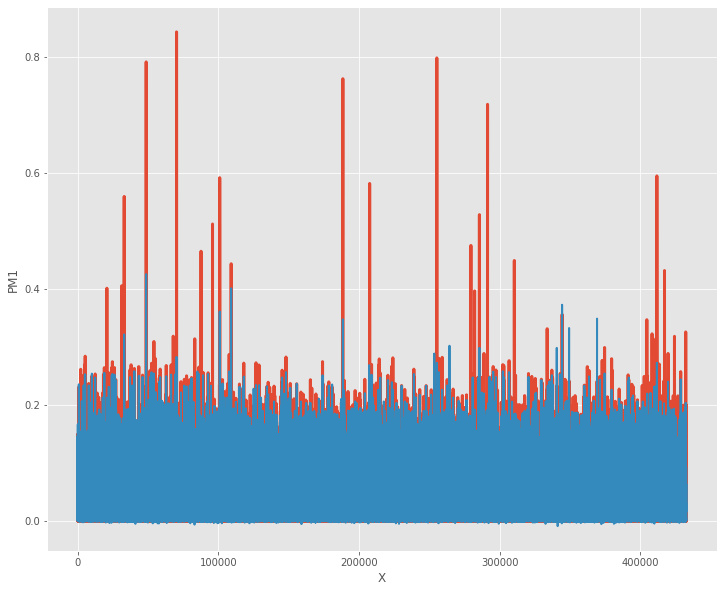

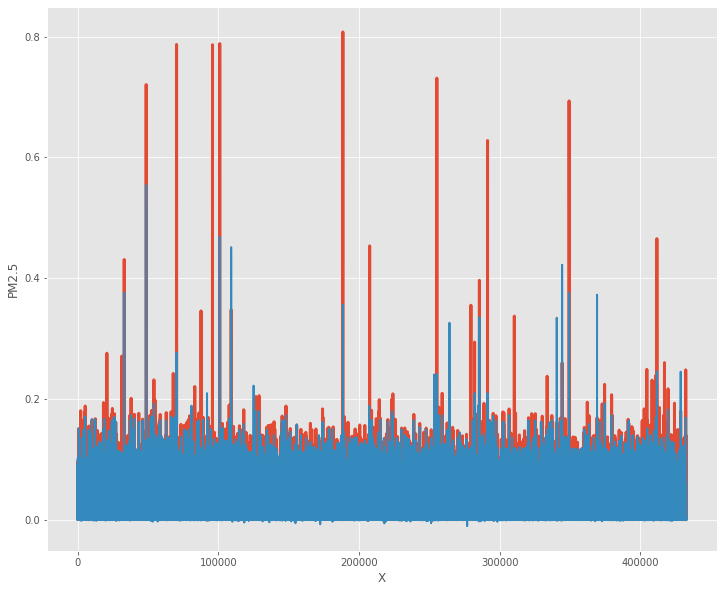

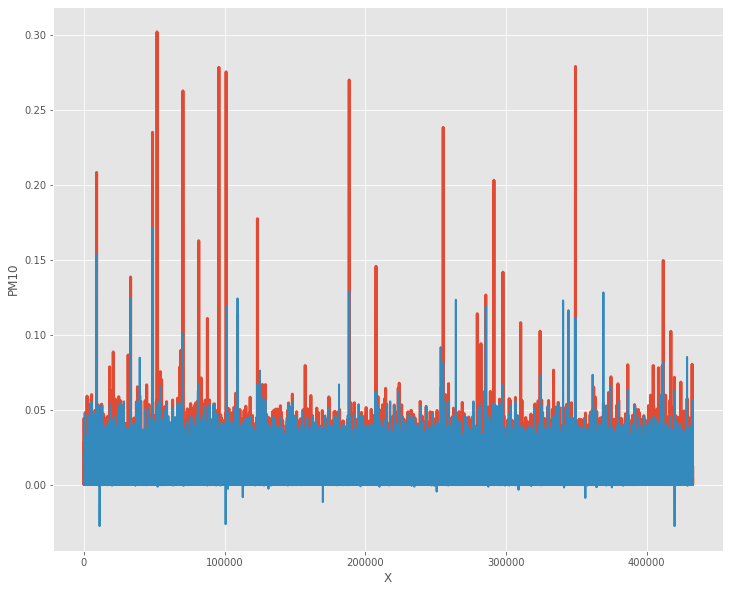

In [14]:
# printing y_test and y_test_predict
print("Y_Test:",y_test)
print("Y_Test_Predict:",y_test_pred1)

from matplotlib import style

style.use('ggplot')

for i in range(0,7):
  plt.figure(figsize=[12,10])
  plt.plot(y_test[:,i],linewidth=3, markersize=12)
  plt.plot(y_test_pred1[:,i],linewidth=2, markersize=12)
  plt.xlabel('X')
  plt.ylabel(train_sizes[i])
  plt.show()